# Experimental Design Capstone

### Introduction: 

###### The Gulf of Mexico (GOM) is considered one of the most prolific oil and gas basins in the world. The basin has produced to date more than 5.2 Billion Barrels of Oil Equivalent (BBOE). The GOM is divided into protraction areas and these protraction areas are further broken into 3 mile by 3 mile lease blocks. The blocks are controled the Beauru of Ocean and Energy Managment. Oil and gas companies with a license to operate in the GOM can bid on available leases in yearly lease sales. Lease terms vary from 5-10 years depending on water depth.

##### One of the jobs of the subsurface staff at an oil and gas company is to monitor competitor lease aquisition. This can show where a specific company, or the industry as a whole, are focusing money and exploration efforts. Competitor intelligence can also help companies create their own strategies for leasing, building exploration campaigns, or provide justification to drill a well. It's important to remember that the lease boudries created by the federal government do not control the geology in the subsurface. Oil and gas fields frequently cross lease boundries, so understanding what targets companies around your own leases and infrastructure are pursuing can help protect your own reserves and identify potential targets for joint ventures and future exploration.

### Hypothesis:

###### Ho: There is no significant difference in the mean bid (USD) per lease block per company between 2014-2020.
###### Ha: There is a significant difference in the mean bid (USD) per lease block per company between 2014-2020

### Data:

###### The data is publicly available on the BOEM website. This dataset was pulled from the GOMSmart database, which organizes lease information into a .csv format. The dataset contains 1708 records and 17 variables. I've only imported 10 variables to be used for this analysis. There are no missing values.


In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

url = "https://github.com/mmcintire00/tf_exp_design/blob/main/gom_ls_high_bids_2014-2020.csv?raw=true"
oil_price = "https://github.com/mmcintire00/tf_exp_design/blob/main/eia_us_monthly_crude_prices_2014-2020.csv?raw=true"

oil_price_df = pd.read_csv(oil_price)
gom_df = pd.read_csv(url, usecols=["Sale No.", "Sale Date", "Area Block", "Total Bid", "% Share", "Net Bid", "Sortname", "Status", "Primary Term"]) # only need these 8 columns for analysis
gom_df = gom_df.rename(columns={'Sortname':'company'}) # rename column for companyies
gom_df = gom_df.rename(columns={'Area Block': 'area_block'})
gom_df = gom_df.rename(columns={'% Share': 'pct_share'})
gom_df = gom_df.rename(columns={'Net Bid': 'net_bid'})
gom_df = gom_df.rename(columns={'Total Bid': 'total_bid'})

In [ ]:
import plotly.graph_objects as go
import ipywidgets as ipy
from plotly.subplots import make_subplots
import plotly.express as px
import re

In [ ]:
gom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708 entries, 0 to 1707
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sale No.      1708 non-null   object 
 1   Sale Date     1708 non-null   object 
 2   area_block    1708 non-null   object 
 3   total_bid     1708 non-null   int64  
 4   company       1708 non-null   object 
 5   pct_share     1708 non-null   float64
 6   net_bid       1708 non-null   float64
 7   Status        1708 non-null   object 
 8   Primary Term  1708 non-null   int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 120.2+ KB


In [ ]:
print(gom_df.isnull().sum())

Sale No.        0
Sale Date       0
area_block      0
total_bid       0
company         0
pct_share       0
net_bid         0
Status          0
Primary Term    0
dtype: int64


In [ ]:
gom_df['year'] = pd.DatetimeIndex(gom_df['Sale Date']).year # create new column with year for grouping
gom_df.head()

,Sale No.,Sale Date,area_block,total_bid,company,pct_share,net_bid,Status,Primary Term,year
0,231,3/19/2014,GC767,18450550,NOBLE ENERGY INC,50.0,9225275.00,PRIMRY,10,2014
1,231,3/19/2014,GC767,18450550,RIDGEWOOD ENERGY CORPORATION,50.0,9225275.00,PRIMRY,10,2014
2,231,3/19/2014,GC816,937555,LLOG BLUEWATER HOLDINGS LLC,70.0,656288.50,RELINQ,10,2014
3,231,3/19/2014,GC816,937555,RED WILLOW OFFSHORE LLC,25.0,234388.75,RELINQ,10,2014
4,231,3/19/2014,GC816,937555,HOUSTON ENERGY LP,5.0,46877.75,RELINQ,10,2014


In [ ]:
oil_price_df.head()

,date,us_crude_price
0,Jan-2014,89.57
1,Feb-2014,96.86
2,Mar-2014,96.17
3,Apr-2014,96.49
4,May-2014,95.74


In [ ]:
# number of bids total per year
gom_df[['total_bid']].groupby(gom_df['year']).agg(['count'])

,total_bid
,count
year,
2014,340
2015,194
2016,179
2017,257
2018,224
2019,353
2020,161


In [ ]:
# sum of net bids from 2014 through 2020
print(int(sum(gom_df['net_bid'])))

2858303852


In [ ]:
# bid statistics for each year
grouped_df = gom_df.groupby(['year']).agg({'net_bid': ['mean', 'min', 'max']})
grouped_df.columns = ['bid_mean', 'bid_min', 'bid_max']
grouped_df.head(7)

,bid_mean,bid_min,bid_max
year,,,
2014,2.672540e+06,18963.8750,68790000.00
2015,2.792015e+06,39129.7000,49612901.65
2016,9.275250e+05,22610.0875,13225126.00
2017,1.453271e+06,19144.1250,24056719.00
2018,1.253246e+06,15144.4250,25919784.00
2019,1.113279e+06,8000.0000,24495776.00
2020,1.209673e+06,62840.0000,11114050.00


#Data Clean-up:

#### Need to clean company names bc some companies report names with slight changes over the time span of analysis.

In [ ]:
# function to normalize company names
def clean_company(c):
  if 'LLOG' in c:
    return 'LLOG'
  elif 'STATOIL' in c:
    return 'EQUINOR GULF OF MEXICO LLC'
  elif 'FREEPORT' in c:
    return 'FREEPORT MCMORAN'
  elif 'ANADARKO' in c:
    return 'ANADARKO'
  elif 'TALOS' in c:
    return 'TALOS ENERGY'
  elif 'DEEP GULF' in c:
    return 'DEEP GULF ENERGY'
  elif 'FIELDWOOD' in c:
    return 'FIELDWOOD ENERGY'
  else:
    return c 

gom_df['clean_company'] = gom_df.company.apply(lambda x: clean_company(x)) 

#### Extract area name from 'area_block' and convert to 'clean_area' for analysis by protraction area.

In [ ]:
# function to filter by protraction area
def protraction_area_filter(x):
  if "MC" in x:
    return "Mississippi Canyon"
  elif "AT" in x:
    return "Atwater Valley"
  elif "GC" in x:
    return "Green Canyon"
  elif "WR" in x:
    return "Walker Ridge"
  elif "KC" in x:
    return "Keathley Canyon"
  elif "GB" in x:
    return "Garden Banks"
  elif "AC" in x:
    return "Alaminos Canyon"
  elif "EB" in x:
    return "East Breaks"
  elif "DC" in x:
    return "Desoto Canyon"
  elif "LL" in x:
    return "Lloyd Ridge"
  else:
    return x

gom_df['clean_area'] = gom_df.area_block.apply(lambda x: protraction_area_filter(x)) 

In [ ]:
gom_df['clean_company'].unique()

array(['NOBLE ENERGY INC', 'RIDGEWOOD ENERGY CORPORATION', 'LLOG',
       'RED WILLOW OFFSHORE LLC', 'HOUSTON ENERGY LP',
       'EQUINOR GULF OF MEXICO LLC', 'FREEPORT MCMORAN', 'ANADARKO',
       'BP EXPLORATION & PRODUCTION INC',
       'COBALT INTERNATIONAL ENERGY LP', 'TOTAL E&P USA INC',
       'CHEVRON USA INC', 'TALOS ENERGY', 'CONOCOPHILLIPS COMPANY',
       'STONE ENERGY OFFSHORE LLC', 'ENI PETROLEUM US LLC',
       'DEEP GULF ENERGY', 'SHELL OFFSHORE INC.',
       'BHP BILLITON PETROLEUM (DEEPWATER) INC',
       'MURPHY EXPLORATION & PRODUCTION COMPANY - USA',
       'REPSOL E&P USA INC', 'MARATHON OIL COMPANY',
       'GULFSLOPE ENERGY INC', 'HESS CORPORATION', 'VENARI OFFSHORE LLC',
       'ENVEN ENERGY VENTURES LLC', 'EXXON MOBIL CORPORATION',
       'ECOPETROL AMERICA INC', 'NAVITAS PETROLEUM US LLC',
       'APACHE SHELF EXPLORATION LLC', 'FIELDWOOD ENERGY',
       'SAMSON OFFSHORE LLC', 'PXP OFFSHORE LLC',
       'UNION OIL COMPANY OF CALIFORNIA', 'FOCUS EXPLORATION LL

#### Keep only companies that submitted bids each year of analysis (2014-2020)

In [ ]:
cleanCompNames = gom_df['clean_company'].unique()

condensed_gom = gom_df[['clean_company', 'year']] # Subset df to just these columns
newGom = condensed_gom.groupby(['clean_company']).agg({'year': ['max']}) # This sucks, but it works
newGom = newGom.reset_index() # reset index 

# Flatten multi-index DF AT THE COLUMN LEVEL (artifact from groupby above) to a 2D object
# allows us to access 1D series (columns)
newGom.columns = newGom.columns.get_level_values(0)

cleanedGom = newGom[newGom['year'] != 2020].reset_index() # Reset index so we don't have out of order indices
cleanedGom = cleanedGom['clean_company'] # Filter to just company names
cleanedGom = cleanedGom.to_list() # turn that into a list object (as opposed to pandas series)

# remove companies that did not submit bids all 7 years of study
gom_clean_df = gom_df[~gom_df['clean_company'].isin(cleanedGom)]
gom_clean_df.head(10)

,Sale No.,Sale Date,area_block,total_bid,company,pct_share,net_bid,Status,Primary Term,year,clean_company,clean_area
1,231,3/19/2014,GC767,18450550,RIDGEWOOD ENERGY CORPORATION,50.0,9225275.00,PRIMRY,10,2014,RIDGEWOOD ENERGY CORPORATION,Green Canyon
2,231,3/19/2014,GC816,937555,LLOG BLUEWATER HOLDINGS LLC,70.0,656288.50,RELINQ,10,2014,LLOG,Green Canyon
3,231,3/19/2014,GC816,937555,RED WILLOW OFFSHORE LLC,25.0,234388.75,RELINQ,10,2014,RED WILLOW OFFSHORE LLC,Green Canyon
4,231,3/19/2014,GC816,937555,HOUSTON ENERGY LP,5.0,46877.75,RELINQ,10,2014,HOUSTON ENERGY LP,Green Canyon
5,231,3/19/2014,GC845,1546207,STATOIL GULF OF MEXICO LLC,100.0,1546207.00,PRIMRY,10,2014,EQUINOR GULF OF MEXICO LLC,Green Canyon
6,231,3/19/2014,GC847,749608,STATOIL GULF OF MEXICO LLC,100.0,749608.00,PRIMRY,10,2014,EQUINOR GULF OF MEXICO LLC,Green Canyon
7,231,3/19/2014,GC890,1215308,STATOIL GULF OF MEXICO LLC,100.0,1215308.00,PRIMRY,10,2014,EQUINOR GULF OF MEXICO LLC,Green Canyon
8,231,3/19/2014,GC891,749608,STATOIL GULF OF MEXICO LLC,100.0,749608.00,PRIMRY,10,2014,EQUINOR GULF OF MEXICO LLC,Green Canyon
11,231,3/19/2014,GC988,757753,RED WILLOW OFFSHORE LLC,75.0,568314.75,PRIMRY,10,2014,RED WILLOW OFFSHORE LLC,Green Canyon
12,231,3/19/2014,GC988,757753,HOUSTON ENERGY LP,25.0,189438.25,PRIMRY,10,2014,HOUSTON ENERGY LP,Green Canyon


In [ ]:
gom_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1386 entries, 1 to 1707
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sale No.       1386 non-null   object 
 1   Sale Date      1386 non-null   object 
 2   area_block     1386 non-null   object 
 3   total_bid      1386 non-null   int64  
 4   company        1386 non-null   object 
 5   pct_share      1386 non-null   float64
 6   net_bid        1386 non-null   float64
 7   Status         1386 non-null   object 
 8   Primary Term   1386 non-null   int64  
 9   year           1386 non-null   int64  
 10  clean_company  1386 non-null   object 
 11  clean_area     1386 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 140.8+ KB


Text(0.5, 1.0, 'US Crude Oil Price')

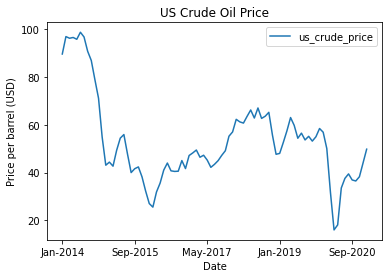

In [ ]:
oil_price_df.plot.line(x='date', y='us_crude_price')
plt.ylabel(ylabel='Price per barrel (USD)')
plt.xlabel(xlabel='Date')
plt.title(label='US Crude Oil Price')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=oil_price_df['date'], y=oil_price_df['us_crude_price'], mode='lines', name='lines'))
fig.update_layout(title_text='Crude Oil Prices 2014-2020')
fig.show()

#### Remove protraction areas that did not recieve bids for all 7 years of analysis (2014-2020)

In [ ]:
# remove protraction areas that do not recieve bids for all 7 years of study
remove_area = ['Lloyd Ridge', 'Desoto Canyon', 'East Breaks']
gom_clean_df = gom_clean_df[~gom_clean_df['clean_area'].isin(remove_area)]
gom_clean_df.head(10)

,Sale No.,Sale Date,area_block,total_bid,company,pct_share,net_bid,Status,Primary Term,year,clean_company,clean_area
1,231,3/19/2014,GC767,18450550,RIDGEWOOD ENERGY CORPORATION,50.0,9225275.00,PRIMRY,10,2014,RIDGEWOOD ENERGY CORPORATION,Green Canyon
2,231,3/19/2014,GC816,937555,LLOG BLUEWATER HOLDINGS LLC,70.0,656288.50,RELINQ,10,2014,LLOG,Green Canyon
3,231,3/19/2014,GC816,937555,RED WILLOW OFFSHORE LLC,25.0,234388.75,RELINQ,10,2014,RED WILLOW OFFSHORE LLC,Green Canyon
4,231,3/19/2014,GC816,937555,HOUSTON ENERGY LP,5.0,46877.75,RELINQ,10,2014,HOUSTON ENERGY LP,Green Canyon
5,231,3/19/2014,GC845,1546207,STATOIL GULF OF MEXICO LLC,100.0,1546207.00,PRIMRY,10,2014,EQUINOR GULF OF MEXICO LLC,Green Canyon
6,231,3/19/2014,GC847,749608,STATOIL GULF OF MEXICO LLC,100.0,749608.00,PRIMRY,10,2014,EQUINOR GULF OF MEXICO LLC,Green Canyon
7,231,3/19/2014,GC890,1215308,STATOIL GULF OF MEXICO LLC,100.0,1215308.00,PRIMRY,10,2014,EQUINOR GULF OF MEXICO LLC,Green Canyon
8,231,3/19/2014,GC891,749608,STATOIL GULF OF MEXICO LLC,100.0,749608.00,PRIMRY,10,2014,EQUINOR GULF OF MEXICO LLC,Green Canyon
11,231,3/19/2014,GC988,757753,RED WILLOW OFFSHORE LLC,75.0,568314.75,PRIMRY,10,2014,RED WILLOW OFFSHORE LLC,Green Canyon
12,231,3/19/2014,GC988,757753,HOUSTON ENERGY LP,25.0,189438.25,PRIMRY,10,2014,HOUSTON ENERGY LP,Green Canyon


In [ ]:
plot = go.Figure(data=go.Violin(x=gom_clean_df['year'], y=gom_clean_df['net_bid']))
plot.update_layout(title_text='Net Lease Bids between 2014-2020')
plot.update_yaxes(title_text='Net Lease Bid (USD)')
plot.update_xaxes(title_text='Year')
plot.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f04c9414a50>,
      dtype=object)

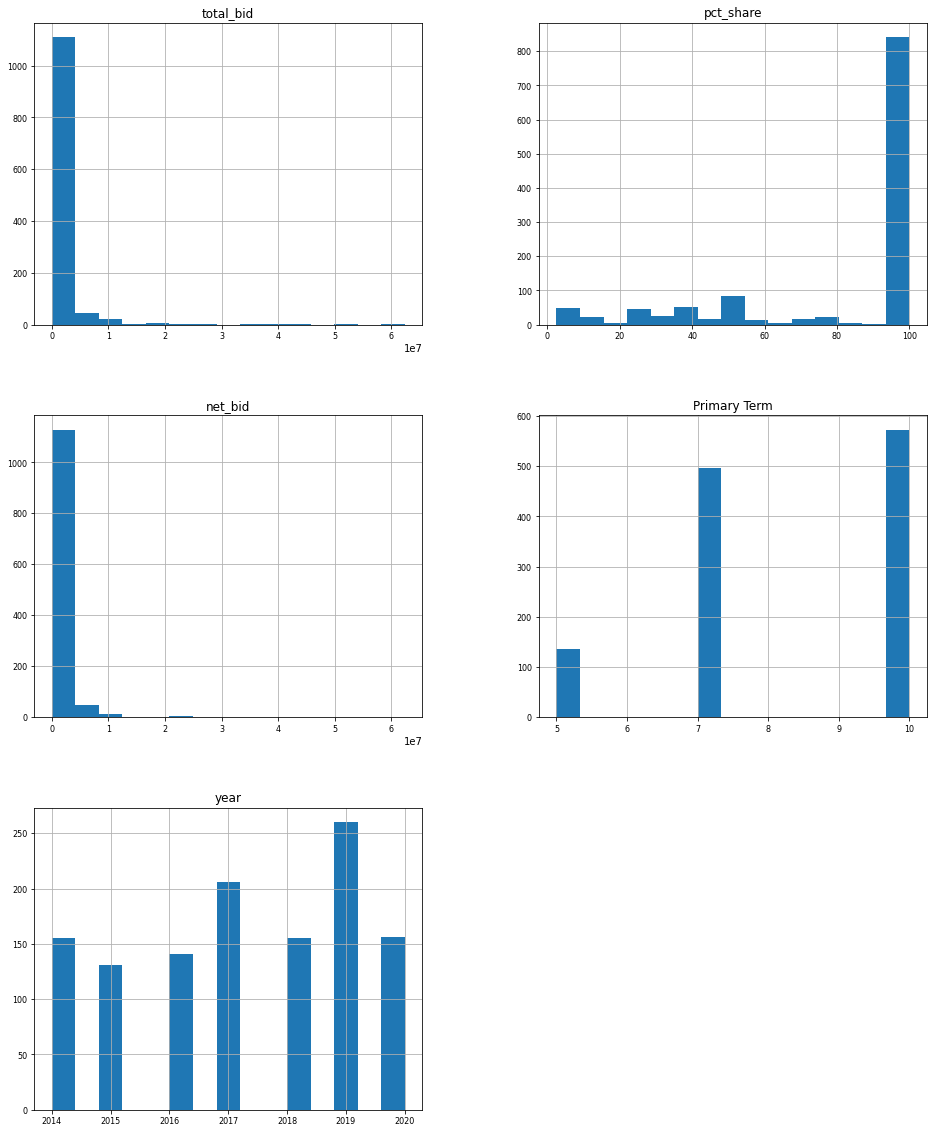

In [ ]:
gom_clean_df.hist(figsize=(16,20), bins=15, xlabelsize=8, ylabelsize=8)

## Data Exploration:

#### Import Seaborn for analysis. Change style to dark.

In [ ]:
import seaborn as sns
sns.set_style('dark')

#### Create dataframe grouped by 'clean_company' and 'year'. also returns 'mean_bid' as  column

In [ ]:
gom_clean_mean_comp_df = gom_clean_df.groupby(['clean_company', 'year'],as_index=False).net_bid.mean()
gom_clean_mean_comp_df = gom_clean_mean_comp_df.rename(columns={'net_bid': 'mean_bid'})
gom_clean_mean_comp_df.head(20)

,clean_company,year,mean_bid
0,ANADARKO,2014,1.354914e+06
1,ANADARKO,2015,1.054771e+06
2,ANADARKO,2016,7.500000e+05
3,ANADARKO,2017,1.174756e+06
4,ANADARKO,2018,2.496378e+06
5,ANADARKO,2019,1.327920e+06
6,ANADARKO,2020,1.618839e+06
7,BEACON OFFSHORE ENERGY EXPLORATION LLC,2018,3.697685e+05
8,BEACON OFFSHORE ENERGY EXPLORATION LLC,2019,7.588155e+05
9,BEACON OFFSHORE ENERGY EXPLORATION LLC,2020,2.660336e+05


#### Pivot table companing mean bid for each company between 2014-2020

In [ ]:
gom_clean_mean_comp_pivot = gom_clean_mean_comp_df.pivot(index='clean_company', columns='year', values='mean_bid')
gom_clean_mean_comp_pivot.head(12)

year,2014,2015,2016,2017,2018,2019,2020
clean_company,,,,,,,
ANADARKO,1.354914e+06,1.054771e+06,7.500000e+05,1.174756e+06,2.496378e+06,1.327920e+06,1.618839e+06
BEACON OFFSHORE ENERGY EXPLORATION LLC,NaN,NaN,NaN,NaN,3.697685e+05,7.588155e+05,2.660336e+05
BHP BILLITON PETROLEUM (DEEPWATER) INC,1.462080e+06,8.439588e+05,3.042849e+06,3.745056e+05,4.130860e+06,2.141915e+06,3.331367e+06
BP EXPLORATION & PRODUCTION INC,1.474602e+06,1.059883e+06,8.399226e+05,5.418415e+05,8.993085e+05,6.804593e+05,1.057090e+06
CHEVRON USA INC,1.586688e+07,7.146583e+06,2.024031e+06,1.813836e+06,1.769308e+06,1.424382e+06,1.424760e+06
CL&F OFFSHORE LLC,NaN,NaN,NaN,1.112109e+05,7.848000e+04,3.024115e+05,6.284000e+04
CSL EXPLORATION LP,NaN,NaN,NaN,NaN,NaN,NaN,1.887225e+05
ENVEN ENERGY VENTURES LLC,6.851770e+05,NaN,NaN,6.030000e+05,8.543191e+05,6.427941e+05,7.542508e+05
EQUINOR GULF OF MEXICO LLC,1.048022e+06,3.673357e+06,1.603307e+06,2.911800e+06,8.216644e+05,3.022304e+06,2.147971e+06


plot mean bids, grouped by company, between 2014-2020

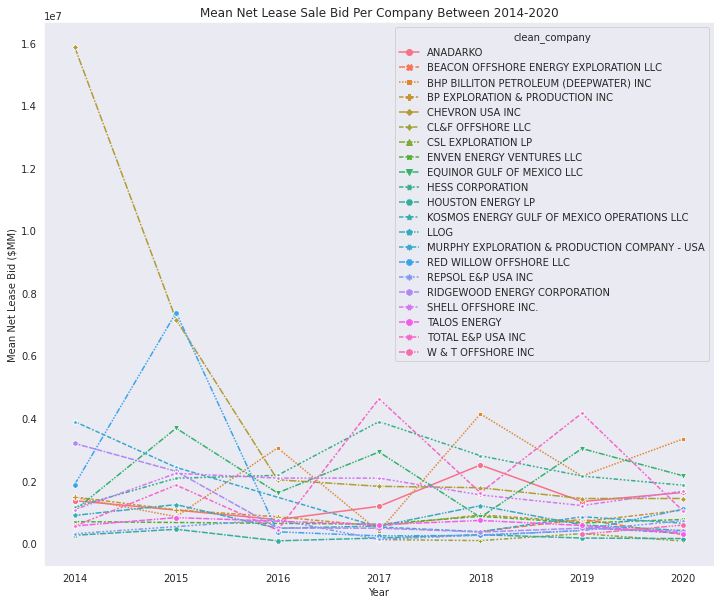

In [ ]:
plt.figure(figsize=(12,10))
plt.title(label='Mean Net Lease Sale Bid Per Company Between 2014-2020')
plt.ylabel(ylabel='Mean Net Lease Bid ($MM)')
plt.xlabel(xlabel='Year')
sns.lineplot(data=gom_clean_mean_comp_df, x='year', y='mean_bid', hue='clean_company', style='clean_company', markers=True)

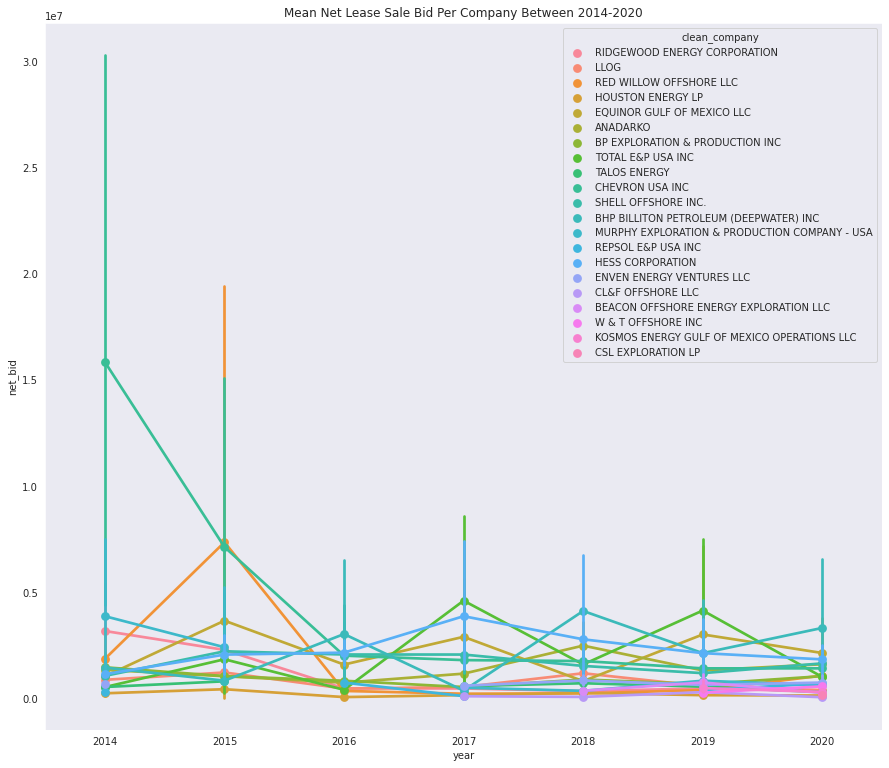

In [ ]:
plt.figure(figsize=(15,13))
plt.title(label='Mean Net Lease Sale Bid Per Company Between 2014-2020')
plt.ylabel(ylabel='Mean Net Lease Bid ($MM)')
plt.xlabel(xlabel='Year')
sns.pointplot(data=gom_clean_df, x='year', y='net_bid', hue='clean_company')


Looking at median this time instead of mean. Create dataframe grouped by 'clean_company' and 'year'. also returns 'median_bid' as column

In [ ]:
gom_clean_median_comp_df = gom_clean_df.groupby(['clean_company', 'year'],as_index=False).net_bid.median()
gom_clean_median_comp_df = gom_clean_median_comp_df.rename(columns={'net_bid': 'median_bid'})
gom_clean_median_comp_df.head(20)

,clean_company,year,median_bid
0,ANADARKO,2014,1155500.000
1,ANADARKO,2015,1203333.000
2,ANADARKO,2016,787500.000
3,ANADARKO,2017,625260.000
4,ANADARKO,2018,3003880.000
5,ANADARKO,2019,705505.000
6,ANADARKO,2020,1578215.000
7,BEACON OFFSHORE ENERGY EXPLORATION LLC,2018,369768.500
8,BEACON OFFSHORE ENERGY EXPLORATION LLC,2019,514080.850
9,BEACON OFFSHORE ENERGY EXPLORATION LLC,2020,220412.500


Pivot table with index=clean_company and columns=year. values are median bids

In [ ]:
gom_clean_median_comp_pivot = gom_clean_median_comp_df.pivot(index='clean_company', columns='year', values='median_bid')
gom_clean_median_comp_pivot.head(12)
gom_clean_median_comp_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, ANADARKO to W & T OFFSHORE INC
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2014    16 non-null     float64
 1   2015    14 non-null     float64
 2   2016    13 non-null     float64
 3   2017    17 non-null     float64
 4   2018    17 non-null     float64
 5   2019    20 non-null     float64
 6   2020    21 non-null     float64
dtypes: float64(7)
memory usage: 1.3+ KB


plot median bids, grouped by company between 2014-2020

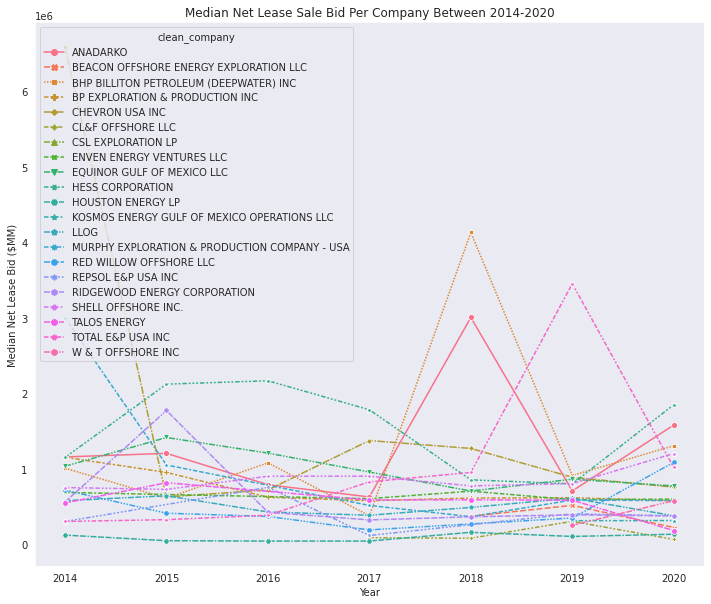

In [ ]:
plt.figure(figsize=(12,10))
plt.title(label='Median Net Lease Sale Bid Per Company Between 2014-2020')
plt.ylabel(ylabel='Median Net Lease Bid ($MM)')
plt.xlabel(xlabel='Year')
sns.lineplot(data=gom_clean_median_comp_df, x='year', y='median_bid', hue='clean_company', style='clean_company', markers=True)

In [ ]:
fig = px.line(data_frame=gom_clean_median_comp_df, x='year', y='median_bid', color='clean_company', title='Median Lease Bid Price per Company Between 2014-2020', width=1200, height=800, hover_data=['clean_company']).for_each_trace(lambda t: t.update(name=t.name.split("=")[1]))
fig.show()

In [ ]:
gom_clean_mean_area_df = gom_clean_df.groupby(['clean_area', 'year'],as_index=False).net_bid.mean()
gom_clean_mean_area_df = gom_clean_mean_area_df.rename(columns={'net_bid': 'mean_bid'})
gom_clean_mean_area_df.head(20)

,clean_area,year,mean_bid
0,Alaminos Canyon,2014,1.652942e+06
1,Alaminos Canyon,2015,6.088880e+05
2,Alaminos Canyon,2016,9.008133e+05
3,Alaminos Canyon,2017,2.197352e+06
4,Alaminos Canyon,2018,1.478622e+06
5,Alaminos Canyon,2019,1.609189e+06
6,Alaminos Canyon,2020,1.255317e+06
7,Atwater Valley,2014,1.751100e+06
8,Atwater Valley,2015,1.099271e+06
9,Atwater Valley,2016,2.082080e+05


In [ ]:
gom_clean_mean_area_pivot = gom_clean_mean_area_df.pivot(index='clean_area', columns='year', values='mean_bid')
gom_clean_mean_area_pivot.head(7)

year,2014,2015,2016,2017,2018,2019,2020
clean_area,,,,,,,
Alaminos Canyon,1.652942e+06,6.088880e+05,9.008133e+05,2.197352e+06,1.478622e+06,1.609189e+06,1.255317e+06
Atwater Valley,1.751100e+06,1.099271e+06,2.082080e+05,3.323054e+06,4.549420e+05,8.061249e+05,6.736971e+05
Garden Banks,6.644522e+05,9.325114e+05,6.207213e+05,1.724607e+06,1.781582e+06,7.734629e+05,8.557376e+05
Green Canyon,1.314117e+06,3.916824e+06,9.796576e+05,1.116057e+06,9.217483e+05,1.134563e+06,1.641427e+06
Keathley Canyon,7.096310e+05,1.394466e+06,7.796458e+05,1.325181e+06,8.101580e+05,1.199269e+06,6.452818e+05
Mississippi Canyon,5.007435e+06,2.360593e+06,1.185099e+06,1.304549e+06,1.896590e+06,1.778580e+06,1.235954e+06
Walker Ridge,6.044766e+05,4.287633e+06,5.025201e+05,2.230396e+06,9.651852e+05,8.898308e+05,1.802950e+06


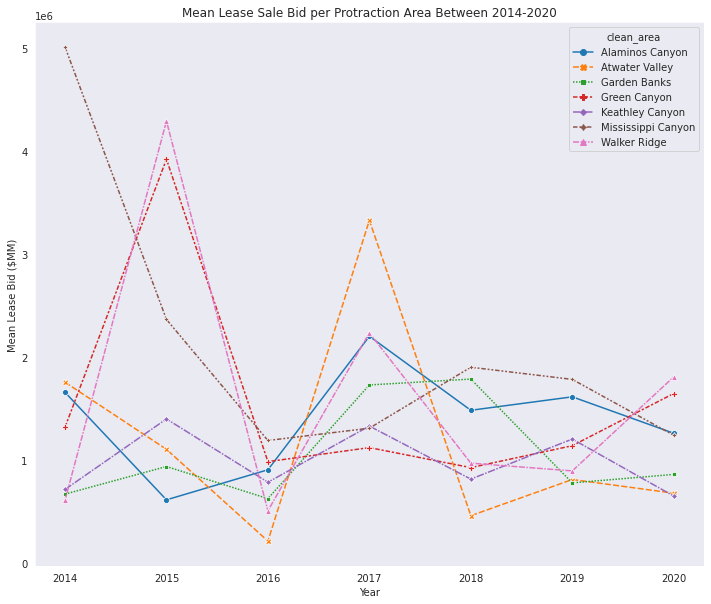

In [ ]:
plt.figure(figsize=(12,10))
plt.title(label='Mean Lease Sale Bid per Protraction Area Between 2014-2020')
plt.ylabel(ylabel='Mean Lease Bid ($MM)')
plt.xlabel(xlabel='Year')
sns.lineplot(data=gom_clean_mean_area_df, x='year', y='mean_bid', hue='clean_area', style='clean_area', markers=True)

In [ ]:
 fig = px.line(data_frame=gom_clean_median_area_df, x='year', y='median_bid', width=1000, color='clean_area', title='Median Lease Bid Price per Protraction Area Between 2014-2020', animation_group='clean_area', labels={'median_bid': 'Median Lease Bid (USD)'})
 fig.show()

NameError: ignored

Looking at median of net bids per area. Create dataframe grouped by 'clean_area' and 'year'. also returns 'median_bid' as column

In [ ]:
gom_clean_median_area_df = gom_clean_df.groupby(['clean_area', 'year'],as_index=False).net_bid.median()
gom_clean_median_area_df = gom_clean_median_area_df.rename(columns={'net_bid': 'median_bid'})
gom_clean_median_area_df.head(20)

Pivot table for median dataframe. index=clean_area, columns=year, values=median_bid

In [ ]:
gom_clean_median_area_pivot = gom_clean_median_area_df.pivot(index='clean_area', columns='year', values='median_bid')
gom_clean_median_area_pivot.head(7)

plot median bids, grouped by area between 2014-2020

In [ ]:
plt.figure(figsize=(12,10))
plt.title(label='Median Lease Sale Bid per Protraction Area Between 2014-2020')
plt.ylabel(ylabel='Median Lease Bid ($MM)')
plt.xlabel(xlabel='Year')
sns.lineplot(data=gom_clean_median_area_df, x='year', y='median_bid', hue='clean_area', style='clean_area', markers=True)

Methods:


In [ ]:
# bid statistics per company per year
grouped_year_company_df = gom_clean_df.groupby(['year','clean_company']).agg({'net_bid': ['mean','median', 'min', 'max', 'count']})
grouped_year_company_df.columns = ['bid_mean', 'bid_median', 'bid_min', 'bid_max', 'bid_count']
grouped_year_company_df.head(30)

Line graphs for mean bid per year for each company in list

In [ ]:
# line graphs for mean bid per year per company
#grouped_year_company_df.sort_values(by ='clean_company', ascending=False).head(10).plot(kind='bar') #top 10 companies 
temp= gom_clean_df.clean_company.unique()
df= grouped_year_company_df.reset_index()
for c in temp: 
  print('company:', c)
  df[df.clean_company==c].groupby('year')['bid_mean','bid_median', 'bid_min', 'bid_max'].mean().plot(kind='line')
  plt.title(label=c)
  plt.xlabel(xlabel='Year')
  plt.ylabel(ylabel='Net Bid Amount ($MM)')
  plt.show()

In [ ]:
# bid statistics per company per year
grouped_year_area_df = gom_clean_df.groupby(['year','clean_area']).agg({'net_bid': ['mean', 'median', 'min', 'max', 'count']})
grouped_year_area_df.columns = ['bid_mean', 'bid_median', 'bid_min', 'bid_max', 'bid_count']
grouped_year_area_df.head(30)

In [ ]:
# bar and ine graphs for mean bid per area per company
#grouped_year_area_df.sort_values(by ='clean_company', ascending=False).head(10).plot(kind='line') #top 10 companies 
temp= gom_clean_df.clean_area.unique()
df= grouped_year_area_df.reset_index()
for c in temp: 
  print('area:', c)
  df[df.clean_area==c].groupby('year')['bid_mean', 'bid_median', 'bid_min', 'bid_max'].mean().plot(kind='line')
  plt.ylabel(ylabel='Bid Amount ($MM)')
  plt.title(label=c)
  plt.show()

In [ ]:
gom_2014_df = gom_clean_df[gom_clean_df['year'] == 2014]
gom_2015_df = gom_clean_df[gom_clean_df['year'] == 2015]
gom_2016_df = gom_clean_df[gom_clean_df['year'] == 2016]
gom_2017_df = gom_clean_df[gom_clean_df['year'] == 2017]
gom_2018_df = gom_clean_df[gom_clean_df['year'] == 2018]
gom_2019_df = gom_clean_df[gom_clean_df['year'] == 2019]
gom_2020_df = gom_clean_df[gom_clean_df['year'] == 2020]

In [ ]:
# mean bids per year per company
gom_14_net_mean =  gom_2014_df.groupby(['clean_company'],as_index=False).net_bid.mean()
gom_15_net_mean =  gom_2015_df.groupby(['clean_company'],as_index=False).net_bid.mean()
gom_16_net_mean =  gom_2016_df.groupby(['clean_company'],as_index=False).net_bid.mean()
gom_17_net_mean =  gom_2017_df.groupby(['clean_company'],as_index=False).net_bid.mean()
gom_18_net_mean =  gom_2018_df.groupby(['clean_company'],as_index=False).net_bid.mean()
gom_19_net_mean =  gom_2019_df.groupby(['clean_company'],as_index=False).net_bid.mean()
gom_20_net_mean =  gom_2020_df.groupby(['clean_company'],as_index=False).net_bid.mean()

In [ ]:
gom_14_net_mean.head()

In [ ]:
plt.hist(gom_14_net_mean['net_bid'], alpha = .3)
plt.hist(gom_15_net_mean['net_bid'], alpha = .3)
plt.hist(gom_16_net_mean['net_bid'], alpha = .3)
plt.hist(gom_17_net_mean['net_bid'], alpha = .3)
plt.hist(gom_18_net_mean['net_bid'], alpha = .3)
plt.hist(gom_19_net_mean['net_bid'], alpha = .3)
plt.hist(gom_20_net_mean['net_bid'], alpha = .3)
plt.legend(['2014','2015','2016','2017','2018','2019','2020'])
plt.xlabel(xlabel='Bid Amount ($MM)')
plt.ylabel(ylabel='# of Bids')
plt.title(label='Comparing Mean Net Bids for 2014-2020')
plt.show()

In [ ]:
means = px.histogram(gom_clean_df, x='net_bid', color='year', title='Net Lease Bids per Year', opacity=.5)
means.show()

In [ ]:
print(stats.describe(gom_14_net_mean['net_bid']))
print(stats.describe(gom_15_net_mean['net_bid']))
print(stats.describe(gom_16_net_mean['net_bid']))
print(stats.describe(gom_17_net_mean['net_bid']))
print(stats.describe(gom_18_net_mean['net_bid']))
print(stats.describe(gom_19_net_mean['net_bid']))
print(stats.describe(gom_20_net_mean['net_bid']))

Comparing median bids per year instead of mean bids

In [ ]:
# median bids per year per company
gom_14_net_median =  gom_2014_df.groupby(['clean_company'],as_index=False).net_bid.median()
gom_15_net_median =  gom_2015_df.groupby(['clean_company'],as_index=False).net_bid.median()
gom_16_net_median =  gom_2016_df.groupby(['clean_company'],as_index=False).net_bid.median()
gom_17_net_median =  gom_2017_df.groupby(['clean_company'],as_index=False).net_bid.median()
gom_18_net_median =  gom_2018_df.groupby(['clean_company'],as_index=False).net_bid.median()
gom_19_net_median =  gom_2019_df.groupby(['clean_company'],as_index=False).net_bid.median()
gom_20_net_median =  gom_2020_df.groupby(['clean_company'],as_index=False).net_bid.median()

In [ ]:
gom_14_net_median.head()

In [ ]:
plt.hist(gom_14_net_median['net_bid'], alpha = .3)
plt.hist(gom_15_net_median['net_bid'], alpha = .3)
plt.hist(gom_16_net_median['net_bid'], alpha = .3)
plt.hist(gom_17_net_median['net_bid'], alpha = .3)
plt.hist(gom_18_net_median['net_bid'], alpha = .3)
plt.hist(gom_19_net_median['net_bid'], alpha = .3)
plt.hist(gom_20_net_median['net_bid'], alpha = .3)
plt.legend(['2014','2015','2016','2017','2018','2019','2020'])
plt.xlabel(xlabel='Bid Amount ($MM)')
plt.ylabel(ylabel='# of Bids')
plt.title(label='Comparing Median Net Bids for 2014-2020')
plt.show()

In [ ]:
fig2 = px.scatter(gom_clean_df, x="net_bid", y="year",
	         size="net_bid", color="clean_company",
                 hover_name="clean_company", size_max=60, width=1000)
fig2.show()

In [ ]:
print(stats.describe(gom_14_net_median['net_bid']))
print(stats.describe(gom_15_net_median['net_bid']))
print(stats.describe(gom_16_net_median['net_bid']))
print(stats.describe(gom_17_net_median['net_bid']))
print(stats.describe(gom_18_net_median['net_bid']))
print(stats.describe(gom_19_net_median['net_bid']))
print(stats.describe(gom_20_net_median['net_bid']))

It appears that results from 2014 are not normal, driven by one outlier bid. 2015-2020 appear to be normal skewness & kurtosis between -3 & 3.

Mean net bids seem relatively normal, with the exception of the 2014 distribution. There appears to be another outlier bid in 2015. This makes sense because oil was hovering around 100 dollars a barrel until September 2014. The second lease sale of the year occured in August 2014. With oil prices high companies were likely more willing to submit large bids for blocks of interest. In 2015, there is another outlier bid relative to the rest of the distribution. Budget cuts may not have taken effect by the first lease sale of the year in March. In 2016 oil dropped below 50 dollars a barrel and the industry was hemorraging cash. All companies cut budgets and laid off large numbers of workers. This can be seen in the mean bid data with mean bids across companies becoming more similar.

kruskal for means, data not normal

In [ ]:
stats.kruskal(gom_14_net_mean['net_bid'], gom_15_net_mean['net_bid'],gom_16_net_mean['net_bid'], gom_17_net_mean['net_bid'], gom_18_net_mean['net_bid'], gom_19_net_mean['net_bid'], gom_20_net_mean['net_bid'])

Means result:  reject null hypothesis. test statistic > 1.96. significant difference in mean lease sale bids between 2014-2020

kruskal for medians, data not normal

In [ ]:
stats.kruskal(gom_14_net_median['net_bid'], gom_15_net_median['net_bid'],gom_16_net_median['net_bid'], gom_17_net_median['net_bid'], gom_18_net_median['net_bid'], gom_19_net_median['net_bid'], gom_20_net_median['net_bid'])

Medians result: reject null hypothesis. test statistic > 1.96. significant difference in median lease sale bids between 2014-2020

pairwise test for mean bids

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_mean = pairwise_tukeyhsd(endog = gom_clean_mean_comp_df['mean_bid'], # comparing mean bid data
                          groups= gom_clean_mean_comp_df['clean_company'], #group by company
                          alpha = 0.05) # significance level
tukey_mean.summary()

Pairwise for medians grouped by company

In [ ]:
tukey_median = pairwise_tukeyhsd(endog = gom_clean_median_comp_df['median_bid'], # comparing mean bid data
                          groups= gom_clean_mean_comp_df['clean_company'], #group by company
                          alpha = 0.05) # significance level
tukey_median.summary()

## Look at meta bid price for top two companies in each year. Will give granular understanding of year wise price without using a point estimate.

## Hypothesis:

* Ho: There is no significant difference in the net bid (USD) for the top two companies in any year.
* Ha: There is a significant difference in the net bid (USD) for the top two companies in any year.

In [ ]:
gom_14_net_count =  gom_2014_df.groupby(['clean_company'],as_index=False).net_bid.count()
gom_15_net_count =  gom_2015_df.groupby(['clean_company'],as_index=False).net_bid.count()
gom_16_net_count =  gom_2016_df.groupby(['clean_company'],as_index=False).net_bid.count()
gom_17_net_count =  gom_2017_df.groupby(['clean_company'],as_index=False).net_bid.count()
gom_18_net_count =  gom_2018_df.groupby(['clean_company'],as_index=False).net_bid.count()
gom_19_net_count =  gom_2019_df.groupby(['clean_company'],as_index=False).net_bid.count()
gom_20_net_count =  gom_2020_df.groupby(['clean_company'],as_index=False).net_bid.count()

Bid count per company between 2014-2020

In [ ]:
# Number of bids submitted per company per year
gom_clean_count_comp_df = gom_clean_df.groupby(['clean_company', 'year'],as_index=False).net_bid.count()
gom_clean_count_comp_df = gom_clean_count_comp_df.rename(columns={'net_bid': 'bid_count'})
gom_clean_count_comp_df.head(20)

In [ ]:
gom_clean_count_comp_pivot = gom_clean_count_comp_df.pivot(index='clean_company', columns='year', values='bid_count')
gom_clean_count_comp_pivot.head(12)

In [ ]:
plt.figure(figsize=(14,12))
plt.title(label='Bid Count per Company Between 2014-2020')
plt.ylabel(ylabel='# of Bids')
plt.xlabel(xlabel='Year')
sns.lineplot(data=gom_clean_count_comp_df, x='year', y='bid_count', hue='clean_company', style='clean_company', markers=True)

In [ ]:
# top 2 bid count companies from 2014
gom_2014_bp = gom_2014_df[gom_2014_df['clean_company'] == 'BP EXPLORATION & PRODUCTION INC']
gom_2014_llog = gom_2014_df[gom_2014_df['clean_company'] == 'LLOG']

In [ ]:
plt.hist(gom_2014_bp['net_bid'], alpha = .3)
plt.hist(gom_2014_llog['net_bid'], alpha = .3)
plt.legend(['BP', 'LLOG'])
plt.xlabel(xlabel='Bid Amount ($MM)')
plt.ylabel(ylabel='# of Bids')
plt.title(label='Comparing Top 2 Companies bids in 2014')
plt.show()

In [ ]:
print(stats.describe(gom_2014_bp['net_bid']))
print(stats.describe(gom_2014_llog['net_bid']))

In [ ]:
stats.kruskal(gom_2014_bp['net_bid'], gom_2014_llog['net_bid'])

2014 results: reject null bc p value less than .05

In [ ]:
# top 2 bid count companies from 2015
gom_2015_bhp = gom_2015_df[gom_2015_df['clean_company'] == 'BHP BILLITON PETROLEUM (DEEPWATER) INC']
gom_2015_shell = gom_2015_df[gom_2015_df['clean_company'] == 'SHELL OFFSHORE INC.']

In [ ]:
plt.hist(gom_2015_bhp['net_bid'], alpha = .3)
plt.hist(gom_2015_shell['net_bid'], alpha = .3)
plt.legend(['BHP', 'Shell'])
plt.xlabel(xlabel='Bid Amount ($MM)')
plt.ylabel(ylabel='# of Bids')
plt.title(label='Comparing Top 2 Companies bids in 2015')
plt.show()

In [ ]:
print(stats.describe(gom_2015_bhp['net_bid']))
print(stats.describe(gom_2015_shell['net_bid']))

skewness and kurtosis within -3 and 3, run t-test

In [ ]:
stats.ttest_ind(gom_2015_bhp['net_bid'], gom_2015_shell['net_bid'])

2015 result: reject null hypothesis bc p-value less than .05

In [ ]:
# top 2 bid count companies from 2016
gom_2016_bp = gom_2016_df[gom_2016_df['clean_company'] == 'BP EXPLORATION & PRODUCTION INC']
gom_2016_hou = gom_2016_df[gom_2016_df['clean_company'] == 'HOUSTON ENERGY LP']

In [ ]:
plt.hist(gom_2016_bp['net_bid'], alpha = .3)
plt.hist(gom_2016_hou['net_bid'], alpha = .3)
plt.legend(['BP', 'Houston Energy'])
plt.xlabel(xlabel='Bid Amount ($MM)')
plt.ylabel(ylabel='# of Bids')
plt.title(label='Comparing Top 2 Companies bids in 2016')
plt.show()

In [ ]:
print(stats.describe(gom_2016_bp['net_bid']))
print(stats.describe(gom_2016_hou['net_bid']))

distribution is not normal -> kruskal wallis

In [ ]:
stats.kruskal(gom_2016_bp['net_bid'], gom_2016_hou['net_bid'])

2016 result: reject null. test statistic greater than 1.96 and p value less than .05

In [ ]:
# top 2 bid count companies from 2017
gom_2017_shell = gom_2017_df[gom_2017_df['clean_company'] == 'SHELL OFFSHORE INC.']
gom_2017_cvx = gom_2017_df[gom_2017_df['clean_company'] == 'CHEVRON USA INC']

In [ ]:
plt.hist(gom_2017_shell['net_bid'], alpha = .3)
plt.hist(gom_2017_cvx['net_bid'], alpha = .3)
plt.legend(['Shell', 'Chevron'])
plt.xlabel(xlabel='Bid Amount ($MM)')
plt.ylabel(ylabel='# of Bids')
plt.title(label='Comparing Top 2 Companies bids in 2017')
plt.show()

In [ ]:
print(stats.describe(gom_2017_shell['net_bid']))
print(stats.describe(gom_2017_cvx['net_bid']))

distribution is not normal -> kruskal wallis

In [ ]:
stats.kruskal(gom_2017_shell['net_bid'], gom_2017_cvx['net_bid'])

2017 result: accept null hypothesis

In [ ]:
# top 2 bid count companies from 2018
gom_2018_eqnr = gom_2018_df[gom_2018_df['clean_company'] == 'EQUINOR GULF OF MEXICO LLC']
gom_2018_cvx = gom_2018_df[gom_2018_df['clean_company'] == 'CHEVRON USA INC']

In [ ]:
plt.hist(gom_2018_eqnr['net_bid'], alpha = .3)
plt.hist(gom_2018_cvx['net_bid'], alpha = .3)
plt.legend(['Equinor', 'Chevron'])
plt.xlabel(xlabel='Bid Amount ($MM)')
plt.ylabel(ylabel='# of Bids')
plt.title(label='Comparing Top 2 Companies bids in 2018')
plt.show()

In [ ]:
print(stats.describe(gom_2018_eqnr['net_bid']))
print(stats.describe(gom_2018_cvx['net_bid']))

distribution is not normal -> kruskal wallis

In [ ]:
stats.kruskal(gom_2018_eqnr['net_bid'], gom_2018_cvx['net_bid'])

2018 result: reject null bc test statistic > 1.96 and p-value < .05

In [ ]:
# top 2 bid count companies from 2019
gom_2019_shell = gom_2019_df[gom_2019_df['clean_company'] == 'SHELL OFFSHORE INC.']
gom_2019_apc = gom_2019_df[gom_2019_df['clean_company'] == 'ANADARKO']

In [ ]:
plt.hist(gom_2019_shell['net_bid'], alpha = .3)
plt.hist(gom_2019_apc['net_bid'], alpha = .3)
plt.legend(['Shell', 'Andarko'])
plt.xlabel(xlabel='Bid Amount ($MM)')
plt.ylabel(ylabel='# of Bids')
plt.title(label='Comparing Top 2 Companies bids in 2019')
plt.show()

In [ ]:
print(stats.describe(gom_2019_shell['net_bid']))
print(stats.describe(gom_2019_apc['net_bid']))

distribution is not normal -> kruskal wallis

In [ ]:
stats.kruskal(gom_2019_shell['net_bid'], gom_2019_apc['net_bid'])

2019 result: accept null hypothesis

In [ ]:
# top 2 bid count companies from 2020
gom_2020_bp = gom_clean_df[gom_clean_df['clean_company'] == 'BP EXPLORATION & PRODUCTION INC']
gom_2020_shell = gom_clean_df[gom_clean_df['clean_company'] == 'SHELL OFFSHORE INC.']

In [ ]:
plt.hist(gom_2020_bp['net_bid'], alpha = .3)
plt.hist(gom_2020_shell['net_bid'], alpha = .3)
plt.legend(['BP', 'Shell'])
plt.xlabel(xlabel='Bid Amount ($MM)')
plt.ylabel(ylabel='# of Bids')
plt.title(label='Comparing Top 2 Companies bids in 2020')
plt.show()

In [ ]:
print(stats.describe(gom_2020_bp['net_bid']))
print(stats.describe(gom_2020_shell['net_bid']))

distribution is not normal -> kruskal wallis

In [ ]:
stats.kruskal(gom_2020_bp['net_bid'], gom_2020_shell['net_bid'])

2020 result: reject null hypothesis bc test statistic > 1.96 and p-value < .05

## Discussion and Conclusions:

##### After performing the one way ANOVA test the p-value is .499, which is greater than .05. We can assume that the means being compared are similar. When looking at the line plots of the mean bids over the given time frame, the mean values plot similarly. 

##### This dataset is interesting beause it captures two major oil price collapses (2015 & 2020). The means may be similar form 2015-2020 because companies became more disciplined in spending in order to conserve money during the downturns. The lease sale in 2014 shows a larger amount and distribution of lease bids submitted possibly due to high oil prices.

## Future Work:

*   Comparing median to account for outlier bids. Should we think about these bids similar to the homeprices example? One really high bid is not an invalid point. Quickly tested this in the above section. comparing mean bid to median bid. 
*   Comparing bid count per company and per area between 2014-2020. This might show emerging exploration areas better than mean bid amount. See below!
*   adding average oil price per year to main dataframe
*   scraping budgets from companies to compare
*   comparing average stock price for publicly traded companies with mean bid or # of bids
*   permits for exploration wells filed by company 
*   total volumes produced per company to measure exploration success
*   number of leases available vs num bids submitted

## Possible bias:
*   sampling bias: In order to complete a more thorough test I needed eliminate companies that did not participate in all 7 years of lease sales. Some of the companies I had to remove were private equity firms that may not have been constrained by a budget scrutinized by the investment community. Could I change null values to zero and rerun analysis?
*   contextual bias: The big one is likely the effect of oil price, which would cause budgets to tighten and making companies less likely to spend more money on lease bids.







## Future Work Testing:

Bid count per area between 2014-2020

In [ ]:
# Number of bids submitted per area per year
gom_clean_count_area_df = gom_clean_df.groupby(['clean_area', 'year'],as_index=False).net_bid.count()
gom_clean_count_area_df = gom_clean_count_area_df.rename(columns={'net_bid': 'bid_count'})
gom_clean_count_area_df.head(20)

In [ ]:
gom_clean_count_area_pivot = gom_clean_count_area_df.pivot(index='clean_area', columns='year', values='bid_count')
gom_clean_count_area_pivot.head(12)

In [ ]:
plt.figure(figsize=(14,12))
plt.title(label='Bid Count per Protraction Area Between 2014-2020')
plt.ylabel(ylabel='# of Bids')
plt.xlabel(xlabel='Year')
sns.lineplot(data=gom_clean_count_area_df, x='year', y='bid_count', hue='clean_area', style='clean_area', markers=True)